In [52]:
import pandas as pd
from datetime import datetime
import datetime
import pytz
import re
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
min_WTI = pd.read_csv(
    'data/cl-1m.csv',
    sep=';',
    header=None,
    names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
)

icom_eia_forecasts = pd.read_csv('InvestingcomEIA.csv')

def standardize_eia_datetime(row):
    """Standardizes datetime for EIA forecast"""
    release_date = pd.to_datetime(row['Release Date'], format='%d-%b-%y', errors='coerce').date()
    release_time = pd.to_datetime(row['Time'], format='%H:%M', errors='coerce').time()

    if pd.isna(release_date) or pd.isna(release_time):
        print('nan')
        return pd.NaT

    combined_datetime = pd.Timestamp.combine(release_date, release_time)
    return combined_datetime

icom_eia_forecasts['Release_Datetime'] = icom_eia_forecasts.apply(standardize_eia_datetime, axis=1)

eastern_tz = pytz.timezone('US/Eastern')
icom_eia_forecasts['Release_Datetime_EST'] = icom_eia_forecasts['Release_Datetime'].dt.tz_localize(eastern_tz, ambiguous='infer', nonexistent='shift_forward')

chicago_tz = pytz.timezone('America/Chicago')
icom_eia_forecasts['Release_Datetime_CST'] = icom_eia_forecasts['Release_Datetime_EST'].dt.tz_convert(chicago_tz)


def standardize_wti_datetime(row):
    """Standardizes datetime for min_WTI dataframe."""
    date_str = row['Date']
    time_str = row['Time']

    combined_datetime = pd.to_datetime(date_str + ' ' + time_str, format='%d/%m/%Y %H:%M:%S', errors='coerce')

    if pd.isna(combined_datetime):
        print('nan')
        return pd.NaT
    return combined_datetime

min_WTI['Datetime'] = min_WTI.apply(standardize_wti_datetime, axis=1)
min_WTI['Datetime_CST'] = min_WTI['Datetime'].dt.tz_localize(chicago_tz, ambiguous='infer', nonexistent='shift_forward')

icom_eia_forecasts = icom_eia_forecasts.set_index('Release_Datetime_CST').sort_index()
min_WTI = min_WTI.set_index('Datetime_CST').sort_index()

min_WTI = min_WTI[~min_WTI.index.duplicated(keep='first')]


# filling in timejumps with 0 activity
min_WTI = min_WTI.resample('min').asfreq()
min_WTI['Close'] = min_WTI['Close'].ffill()
min_WTI['Open'] = min_WTI['Open'].fillna(min_WTI['Close'])
min_WTI['High'] = min_WTI['High'].fillna(min_WTI['Close'])
min_WTI['Low'] = min_WTI['Low'].fillna(min_WTI['Close'])
min_WTI['Volume'] = min_WTI['Volume'].fillna(0)
min_WTI['Date'] = min_WTI['Date'].ffill()

min_WTI = min_WTI.reset_index()

min_WTI['Datetime_CST'] = pd.to_datetime(min_WTI['Datetime_CST'])
min_WTI['Time'] = min_WTI['Datetime_CST'].dt.strftime('%H:%M:%S')
min_WTI['Datetime'] = min_WTI['Datetime_CST'].dt.strftime('%Y-%m-%d %H:%M:%S')
min_WTI.set_index('Datetime_CST', inplace=True)


def get_price_windows(eia_release_times, price_data, window_minutes_before=60, window_minutes_after=60):
    """
    Extracts price data windows around EIA report release times.

    Args:
        eia_release_times (pd.DatetimeIndex): Index of icom_eia_forecasts (release datetimes).
        price_data (pd.DataFrame): min_res_OIH dataframe with Datetime index.
        window_minutes_before (int): Minutes to include before release time.
        window_minutes_after (int): Minutes to include after release time.

    Returns:
        pd.DataFrame: A DataFrame containing price data for all events, within the specified windows.
                      Returns an empty DataFrame if no data is found within any window.
    """
    price_windows_list = []

    for release_time in eia_release_times:
        start_time = release_time - pd.Timedelta(minutes=window_minutes_before)

        end_time = release_time + pd.Timedelta(minutes=window_minutes_after)

        window_data = price_data.loc[start_time:end_time].copy()


        if not window_data.empty:
            window_data['Release_Datetime'] = release_time
            price_windows_list.append(window_data)

    if price_windows_list:
        price_windows_df = pd.concat(price_windows_list)
        return price_windows_df
    else:
        return pd.DataFrame()

price_window_60min = get_price_windows(icom_eia_forecasts.index, min_WTI, window_minutes_before=60, window_minutes_after=60)

price_window_60min = price_window_60min.reset_index()

price_window_60min['Time_to_Release_Minutes'] = (price_window_60min['Datetime_CST'] - price_window_60min['Release_Datetime']).dt.total_seconds() / 60

valid_releases = price_window_60min.loc[price_window_60min['Time_to_Release_Minutes'] == 2]
price_window_60min = price_window_60min[price_window_60min['Date'].isin(valid_releases['Date'])]
price_window_60min = price_window_60min[price_window_60min['Time_to_Release_Minutes'] <= 2]

def pivot_market_data(df, x_minutes_before, cols_to_pivot=None):
    """
    pivot into wide formate where minutes to release from [-x, 2] are kept as columns for each feature.
    """
    if cols_to_pivot is None:
        cols_to_pivot = ['Open', 'High', 'Low', 'Close', 'Volume']

    df_filtered = df[(df['Time_to_Release_Minutes'] <= 2) & (df['Time_to_Release_Minutes'] >= -x_minutes_before)].copy()

    df_long = df_filtered.melt(
        id_vars=['Datetime', 'Time_to_Release_Minutes', 'Release_Datetime'],
        value_vars=cols_to_pivot,
        var_name='Feature',
        value_name='Value'
    )
    df_long['Feature_min'] = df_long['Feature'] + '_t' + df_long['Time_to_Release_Minutes'].astype(int).astype(str)

    df_wide = df_long.pivot_table(
        index='Release_Datetime',
        columns='Feature_min',
        values='Value'
    ).reset_index()
    cols_to_drop = [col for col in df_wide.columns if 't2' in col and col != 'Close_t2']
    df_wide.drop(columns=cols_to_drop, inplace=True)
    return df_wide

df_wide = pivot_market_data(price_window_60min, x_minutes_before=60)

def get_time_offset(col_name):
    match = re.search(r't(-?\d+)$', col_name)
    if match: return int(match.group(1))
    return float('inf')

sorted_market_cols = sorted(df_wide.columns, key=get_time_offset)
df_wide = df_wide[sorted_market_cols]
df_wide.set_index('Release_Datetime', inplace=True)
df_wide['Price_Change'] = df_wide['Close_t2'] - df_wide['Open_t0']
#df_wide is now sorted

In [ ]:
#start with just price data
df_wide['Pct_Change'] = (df_wide['Close_t2'] - df_wide['Open_t0']) / df_wide['Open_t0'] * 100
column_names = []
variable_names = ['Open', 'High', 'Low', 'Close', 'Volume']
for var_name in variable_names:
    for min in range(60):
        column_names.append(f'{var_name}_t{min-60}')

column_names.append('Open_t0')

n_total_events = len(df_wide)
test_set_size_ratio = 0.2

test_set_split_index = int(n_total_events * (1 - test_set_size_ratio))

# Data for hyperparameter tuning and training the final model
X_tuning_full = df_wide.iloc[:test_set_split_index][column_names]
y_tuning_full = df_wide.iloc[:test_set_split_index]['Pct_Change']

# Final hold-out test set (never seen during tuning)
X_test_holdout = df_wide.iloc[test_set_split_index:][column_names]
y_test_holdout = df_wide.iloc[test_set_split_index:]['Pct_Change']

print(f"Full dataset size: {len(df_wide)}")
print(f"Tuning dataset size: {len(X_tuning_full)}")
print(f"Hold-out test dataset size: {len(X_test_holdout)}")

Full dataset size: 731
Tuning dataset size: 584
Hold-out test dataset size: 147


In [ ]:
hyperparam_grid = {
    'n_estimators': [1000],  # Max number of trees; early stopping will determine the optimal.
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 7, 8],
    'subsample': [0.85, 0.9, 0.95],
    'colsample_bytree': [0.85, 0.9, 0.95],
    'reg_alpha': [0.1, 0.3, 0.5],      # L1 regularization
    'reg_lambda': [3, 4, 5],
}

param_list = list(ParameterGrid(hyperparam_grid))


tscv = TimeSeriesSplit(n_splits=3) # Or 5, depending on dataset size and computational budget
results = []
early_stopping_rounds_val = 10 # Number of rounds for early stopping


epsilon = 1e-6 # To avoid zero weights if Pct_Change can be 0
weights_tuning_full = np.abs(y_tuning_full) + epsilon
weights_test_holdout = np.abs(y_test_holdout) + epsilon


print(f"Starting hyperparameter tuning with TimeSeriesSplit. Total combinations: {len(param_list)}")
for fold, (train_index, val_index) in enumerate(tscv.split(X_tuning_full)):
    print(f"\nFold {fold+1}/{tscv.get_n_splits()}")
    X_train_fold, y_train_fold = X_tuning_full.iloc[train_index], y_tuning_full.iloc[train_index]
    X_val_fold, y_val_fold = X_tuning_full.iloc[val_index], y_tuning_full.iloc[val_index]
    weights_train_fold = weights_tuning_full.iloc[train_index]
    weights_val_fold = weights_tuning_full.iloc[val_index]

    print(f"  Training on {len(X_train_fold)} instances, validating on {len(X_val_fold)} instances.")


    for i, params in enumerate(param_list):
        if (i + 1) % 10 == 0 or i == 0 or i == len(param_list) -1 : # Print progress
             print(f"    Combination {i+1}/{len(param_list)}: {params}")

        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=42, # For reproducibility of XGBoost model itself
            early_stopping_rounds=early_stopping_rounds_val,
            n_jobs=-1,       # Use all available CPU cores
            **params         # Unpack current hyperparameter combination
        )

        model.fit(X_train_fold, y_train_fold,
                  sample_weight=weights_train_fold, # Weights for training
                  #eval_set=[(X_val_fold, y_val_fold, val_weights)], # Pass weights for eval set
                  # If XGBoost version is older and doesn't support weights in eval_set tuple:
                  eval_set=[(X_val_fold, y_val_fold)],
                  sample_weight_eval_set=[weights_val_fold], # Use this instead for older XGBoost
                  verbose=False)

        y_pred_val = model.predict(X_val_fold)
        val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val, sample_weight=weights_val_fold))

        # **HIGHLIGHT 3: Store all tuned parameters and the actual number of estimators used.**
        result_entry = params.copy() # Start with all parameters from the grid
        result_entry['fold'] = fold + 1
        result_entry['val_rmse'] = val_rmse
        # `best_iteration` is available if early stopping was used and is 0-indexed.
        # `best_ntree_limit` is 1-indexed for the number of trees.
        result_entry['actual_n_estimators'] = model.best_iteration
        results.append(result_entry)

results_df = pd.DataFrame(results)

# Aggregate results: Calculate mean validation RMSE and mean actual_n_estimators for each hyperparameter combination.
# **HIGHLIGHT 4: Group by all hyperparameters that were varied.**
grouping_cols = [col for col in focused_hyperparam_grid.keys() if col != 'n_estimators'] # n_estimators is fixed high
# If n_estimators were part of the grid to iterate over, it would be included here.
# For this specific grid, n_estimators is fixed at 1000 initially, so we don't group by it
# in the same way if it were a varying parameter. However, since it's in `params`,
# it will be naturally included if we just use `list(focused_hyperparam_grid.keys())`.

# We care about the performance for each setting of lr, max_depth etc.
# and want to know the avg optimal trees found by early stopping for those settings.
average_metrics_across_folds = results_df.groupby(grouping_cols).agg(
    avg_val_rmse=('val_rmse', 'mean'),
    avg_actual_n_estimators=('actual_n_estimators', 'mean') # Average the number of trees found by early stopping
).reset_index()


# Find the best hyperparameters based on the minimum average validation RMSE.
best_params_row = average_metrics_across_folds.loc[average_metrics_across_folds['avg_val_rmse'].idxmin()]

# Extract all best parameters
best_hyperparams = best_params_row.to_dict()
best_hyperparams['max_depth'] = int(best_hyperparams.get('max_depth'))
best_avg_rmse = best_hyperparams.pop('avg_val_rmse') # Remove so it's not passed to XGBRegressor
# **HIGHLIGHT 5: Use the averaged actual_n_estimators for the final model.**
# Or, you could re-train with early stopping on the full dev set. This uses the average.
best_actual_n_estimators = int(round(best_hyperparams.pop('avg_actual_n_estimators')))


print("\nBest hyperparameters found via TimeSeriesSplit CV:")
for param_name, param_val in best_hyperparams.items():
    print(f"  {param_name}: {param_val}")
print(f"  (Best actual n_estimators found by early stopping, averaged): {best_actual_n_estimators}")
print(f"  Average Validation RMSE across folds: {best_avg_rmse:.4f}")

Starting hyperparameter tuning with TimeSeriesSplit. Total combinations: 729

Fold 1/3
  Training on 148 instances, validating on 146 instances.
    Combination 1/729: {'colsample_bytree': 0.85, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 3, 'subsample': 0.85}
    Combination 10/729: {'colsample_bytree': 0.85, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000, 'reg_alpha': 0.3, 'reg_lambda': 3, 'subsample': 0.85}
    Combination 20/729: {'colsample_bytree': 0.85, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000, 'reg_alpha': 0.5, 'reg_lambda': 3, 'subsample': 0.9}
    Combination 30/729: {'colsample_bytree': 0.85, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 3, 'subsample': 0.95}
    Combination 40/729: {'colsample_bytree': 0.85, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'reg_alpha': 0.3, 'reg_lambda': 4, 'subsample': 0.85}
    Combination 50/729: {'c

In [ ]:
print("\n--- Training Final Model with Best Hyperparameters ---")

# Tweak 2: Use the best hyperparameters and optimal n_estimators.
# Remove any keys from best_hyperparams that are not actual XGBoost parameters
# (your current aggregation logic seems to handle this already by popping them).
params_for_final_model = best_hyperparams.copy()

final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    n_estimators=best_actual_n_estimators,
    **params_for_final_model
)

# Tweak 3: Train the final model on the ENTIRE tuning dataset (X_tuning_full, y_tuning_full).
print(f"Training final model on {len(X_tuning_full)} instances.")
final_model.fit(X_tuning_full, y_tuning_full,
                sample_weight=weights_tuning_full,
                verbose=False)

print("\n--- Evaluating Final Model on Hold-Out Test Set ---")
y_pred_test_holdout = final_model.predict(X_test_holdout)

# Calculate performance metrics on the hold-out test set
test_rmse = np.sqrt(mean_squared_error(y_test_holdout, y_pred_test_holdout,
                                       sample_weight=weights_test_holdout))

print(f"Final Model Performance on Hold-Out Test Set:")
print(f"  Test RMSE: {test_rmse:.6f}") # Using more precision for RMSE

# Tweak 4: Baseline Model Comparison (Lecture 5, pg 5)
# A simple baseline for percentage change is to predict zero change.
baseline_pred_zero = np.zeros_like(y_test_holdout)
baseline_rmse_zero = np.sqrt(mean_squared_error(y_test_holdout, baseline_pred_zero,
                                                 sample_weight=weights_test_holdout))

print(f"\nBaseline Model (Predict Zero Change) Performance on Hold-Out Test Set:")
print(f"  Baseline RMSE: {baseline_rmse_zero:.6f}")

if test_rmse < baseline_rmse_zero:
    print("\nConclusion: The XGBoost model performs better than the baseline (predicting zero change).")
else:
    print("\nConclusion: The XGBoost model does NOT perform better than the baseline (predicting zero change). Further investigation or model refinement needed.")

# Optional: Feature Importance from the final model (Lecture 9, pg 13-14)
# This can give insights into what drives the predictions.
try:
    feature_importances = final_model.feature_importances_
    importance_df = pd.DataFrame({'feature': X_tuning_full.columns, 'importance': feature_importances})
    importance_df = importance_df.sort_values(by='importance', ascending=False)
    print("\nTop 10 Feature Importances from Final Model:")
    print(importance_df.head(10))
except Exception as e:
    print(f"Could not retrieve feature importances: {e}")


--- Training Final Model with Best Hyperparameters ---
Training final model on 586 instances.

--- Evaluating Final Model on Hold-Out Test Set ---
Final Model Performance on Hold-Out Test Set:
  Test RMSE: 0.393174

Baseline Model (Predict Zero Change) Performance on Hold-Out Test Set:
  Baseline RMSE: 0.402660

Conclusion: The XGBoost model performs better than the baseline (predicting zero change).

Top 10 Feature Importances from Final Model:
         feature  importance
261  Volume_t-39    0.206890
248  Volume_t-52    0.066634
0      Open_t-60    0.059081
295   Volume_t-5    0.055731
251  Volume_t-49    0.053814
271  Volume_t-29    0.051934
297   Volume_t-3    0.035970
4      Open_t-56    0.034913
301       Actual    0.032565
244  Volume_t-56    0.029560


In [ ]:
df_wide.reset_index(inplace=True)
df_wide['Release Date'] = df_wide['Release_Datetime'].dt.date
df_wide = df_wide.drop(columns=['Release_Datetime']).set_index('Release Date')

weekly_supply=pd.read_csv("InvestingcomEIA.csv")
weekly_supply['Release Date'] = pd.to_datetime(weekly_supply['Release Date'], format="%d-%b-%y").dt.strftime("%Y-%m-%d")
weekly_supply.set_index('Release Date', inplace=True)


weekly_prod=pd.read_csv("weekly_prod.csv", header=2)


weekly_import=pd.read_csv("net_import.csv")

df_wide = df_wide.sort_index()
df_wide.reset_index(inplace=True)
weekly_supply = weekly_supply.sort_index()
weekly_supply.reset_index(inplace=True)

df_wide['Release Date'] = pd.to_datetime(df_wide['Release Date'])
weekly_supply['Release Date'] = pd.to_datetime(weekly_supply['Release Date'])
price_supply = pd.merge(df_wide, weekly_supply, how='left', on='Release Date')

weekly_prod['Date'] = pd.to_datetime(weekly_prod['Date'])
weekly_import['Date'] = pd.to_datetime(weekly_import['Date'])

prod_import = pd.merge(weekly_import, weekly_prod, how='left', on='Date').dropna()

In [ ]:
mapping = pd.read_csv('FXmappings.csv')
split_data = mapping['Date'].str.split('(', expand=True)

mapping['ReleaseDate_str'] = split_data[0].str.strip()

mapping['end_date'] = split_data[1].str.rstrip(')').str.strip()

mapping['ReleaseDate'] = pd.to_datetime(mapping['ReleaseDate_str'], format='%m/%d/%Y')
mapping.drop(columns=['ReleaseDate_str', 'Date'], inplace=True)

release_year = mapping['ReleaseDate'].dt.year

full_end_date = mapping['end_date'] + ' ' + release_year.astype(str)

mapping['end_date'] = pd.to_datetime(full_end_date, format='%b %d %Y')

mapping['day_before'] = mapping['ReleaseDate'] - pd.Timedelta(days=1)

dow = mapping['day_before'].dt.dayofweek

days_to_subtract = (dow + 3) % 7

mapping['end_date'] = mapping['day_before'] - pd.to_timedelta(days_to_subtract, unit='D')

mapping.drop(columns=['day_before'], inplace=True)
mapping['end_date'] = pd.to_datetime(mapping['end_date'])
mapping = mapping.set_index('end_date').sort_index()
mapping.reset_index(inplace=True)

prod_import_mapped = pd.merge(mapping, prod_import, how='left', right_on='Date', left_on='end_date')
prod_import_mapped.drop(columns=['end_date', 'Date'], inplace=True)

full_data = pd.merge(price_supply, prod_import_mapped, how='left', left_on='Release Date', right_on='ReleaseDate')

full_data.drop(columns=['Time', 'ReleaseDate'], inplace=True)
full_data['Weekly Net Import'] = full_data['Weekly Net Import'] * 7
full_data['Weekly Production'] = full_data['Weekly U.S. Field Production of Crude Oil  (Thousand Barrels per Day)'] * 7

full_data = full_data.drop(columns=['Weekly U.S. Field Production of Crude Oil  (Thousand Barrels per Day)'])
full_data = full_data.dropna()


def convert_to_numeric(value):
    multiplier = 1_000_000
    numeric_part = value[:-1]

    try:
        return float(numeric_part) * multiplier
    except ValueError:
        return np.nan


for col in ['Actual', 'Forecast', 'Previous']:

    full_data[col] = full_data[col].apply(convert_to_numeric)

for col in ['Weekly Net Import', 'Weekly Production']:
    full_data[col] = full_data[col].apply(lambda x: x * 1000)

In [90]:
display(full_data.columns)

Index(['Release Date', 'Close_t-60', 'High_t-60', 'Low_t-60', 'Open_t-60',
       'Volume_t-60', 'Close_t-59', 'High_t-59', 'Low_t-59', 'Open_t-59',
       ...
       'Open_t1', 'Volume_t1', 'Close_t2', 'Price_Change', 'Pct_Change',
       'Actual', 'Forecast', 'Previous', 'Weekly Net Import',
       'Weekly Production'],
      dtype='object', length=319)

In [91]:
column_names = []
variable_names = ['Open', 'High', 'Low', 'Close', 'Volume']
for var_name in variable_names:
    for min in range(60):
        column_names.append(f'{var_name}_t{min-60}')

column_names.append('Open_t0')

new_cols = ['Actual', 'Forecast', 'Previous', 'Weekly Net Import','Weekly Production']
for col_name in new_cols:
    column_names.append(col_name)

n_total_events = len(full_data)
test_set_size_ratio = 0.2

test_set_split_index = int(n_total_events * (1 - test_set_size_ratio))

# Data for hyperparameter tuning and training the final model
X_tuning_full = full_data.iloc[:test_set_split_index][column_names]
y_tuning_full = full_data.iloc[:test_set_split_index]['Pct_Change']

# Final hold-out test set (never seen during tuning)
X_test_holdout = full_data.iloc[test_set_split_index:][column_names]
y_test_holdout = full_data.iloc[test_set_split_index:]['Pct_Change']

print(f"Full dataset size: {len(df_wide)}")
print(f"Tuning dataset size: {len(X_tuning_full)}")
print(f"Hold-out test dataset size: {len(X_test_holdout)}")

Full dataset size: 731
Tuning dataset size: 586
Hold-out test dataset size: 147


In [92]:
hyperparam_grid = {
    'n_estimators': [1000],  # Max number of trees; early stopping will determine the optimal.
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [6, 7, 8],
    'subsample': [0.85, 0.9, 0.95],
    'colsample_bytree': [0.85, 0.9, 0.95],
    'reg_alpha': [0.3, 0.5, 0.8],      # L1 regularization
    'reg_lambda': [4, 5, 9],
}

param_list = list(ParameterGrid(hyperparam_grid))


tscv = TimeSeriesSplit(n_splits=3) # Or 5, depending on dataset size and computational budget
results = []
early_stopping_rounds_val = 10 # Number of rounds for early stopping

print(f"Starting hyperparameter tuning with TimeSeriesSplit. Total combinations: {len(param_list)}")
for fold, (train_index, val_index) in enumerate(tscv.split(X_tuning_full)):
    print(f"\nFold {fold+1}/{tscv.get_n_splits()}")
    X_train_fold, y_train_fold = X_tuning_full.iloc[train_index], y_tuning_full.iloc[train_index]
    X_val_fold, y_val_fold = X_tuning_full.iloc[val_index], y_tuning_full.iloc[val_index]

    print(f"  Training on {len(X_train_fold)} instances, validating on {len(X_val_fold)} instances.")

    for i, params in enumerate(param_list):
        if (i + 1) % 10 == 0 or i == 0 or i == len(param_list) -1 : # Print progress
             print(f"    Combination {i+1}/{len(param_list)}: {params}")

        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=42, # For reproducibility of XGBoost model itself
            early_stopping_rounds=early_stopping_rounds_val,
            n_jobs=-1,       # Use all available CPU cores
            **params         # Unpack current hyperparameter combination
        )

        # **HIGHLIGHT 2: Fit with early stopping on the validation set of the current fold.**
        # The `n_estimators` from `params` (e.g., 1000) acts as the maximum.
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)], # Evaluate on the current fold's validation set
                  verbose=False) # Suppress XGBoost's training output for cleaner logs

        y_pred_val = model.predict(X_val_fold)
        val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))

        # **HIGHLIGHT 3: Store all tuned parameters and the actual number of estimators used.**
        result_entry = params.copy() # Start with all parameters from the grid
        result_entry['fold'] = fold + 1
        result_entry['val_rmse'] = val_rmse
        # `best_iteration` is available if early stopping was used and is 0-indexed.
        # `best_ntree_limit` is 1-indexed for the number of trees.
        result_entry['actual_n_estimators'] = model.best_iteration
        results.append(result_entry)

results_df = pd.DataFrame(results)

# Aggregate results: Calculate mean validation RMSE and mean actual_n_estimators for each hyperparameter combination.
# **HIGHLIGHT 4: Group by all hyperparameters that were varied.**
grouping_cols = [col for col in focused_hyperparam_grid.keys() if col != 'n_estimators'] # n_estimators is fixed high
# If n_estimators were part of the grid to iterate over, it would be included here.
# For this specific grid, n_estimators is fixed at 1000 initially, so we don't group by it
# in the same way if it were a varying parameter. However, since it's in `params`,
# it will be naturally included if we just use `list(focused_hyperparam_grid.keys())`.

# We care about the performance for each setting of lr, max_depth etc.
# and want to know the avg optimal trees found by early stopping for those settings.
average_metrics_across_folds = results_df.groupby(grouping_cols).agg(
    avg_val_rmse=('val_rmse', 'mean'),
    avg_actual_n_estimators=('actual_n_estimators', 'mean') # Average the number of trees found by early stopping
).reset_index()


# Find the best hyperparameters based on the minimum average validation RMSE.
best_params_row = average_metrics_across_folds.loc[average_metrics_across_folds['avg_val_rmse'].idxmin()]

# Extract all best parameters
best_hyperparams = best_params_row.to_dict()
best_hyperparams['max_depth'] = int(best_hyperparams.get('max_depth'))
best_avg_rmse = best_hyperparams.pop('avg_val_rmse') # Remove so it's not passed to XGBRegressor
# **HIGHLIGHT 5: Use the averaged actual_n_estimators for the final model.**
# Or, you could re-train with early stopping on the full dev set. This uses the average.
best_actual_n_estimators = int(round(best_hyperparams.pop('avg_actual_n_estimators')))


print("\nBest hyperparameters found via TimeSeriesSplit CV:")
for param_name, param_val in best_hyperparams.items():
    print(f"  {param_name}: {param_val}")
print(f"  (Best actual n_estimators found by early stopping, averaged): {best_actual_n_estimators}")
print(f"  Average Validation RMSE across folds: {best_avg_rmse:.4f}")

Starting hyperparameter tuning with TimeSeriesSplit. Total combinations: 729

Fold 1/3
  Training on 148 instances, validating on 146 instances.
    Combination 1/729: {'colsample_bytree': 0.85, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1000, 'reg_alpha': 0.3, 'reg_lambda': 4, 'subsample': 0.85}
    Combination 10/729: {'colsample_bytree': 0.85, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1000, 'reg_alpha': 0.5, 'reg_lambda': 4, 'subsample': 0.85}
    Combination 20/729: {'colsample_bytree': 0.85, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1000, 'reg_alpha': 0.8, 'reg_lambda': 4, 'subsample': 0.9}
    Combination 30/729: {'colsample_bytree': 0.85, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000, 'reg_alpha': 0.3, 'reg_lambda': 4, 'subsample': 0.95}
    Combination 40/729: {'colsample_bytree': 0.85, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000, 'reg_alpha': 0.5, 'reg_lambda': 5, 'subsample': 0.85}
    Combination 50/729: {'c

In [93]:
print("\n--- Training Final Model with Best Hyperparameters ---")

# Tweak 2: Use the best hyperparameters and optimal n_estimators.
# Remove any keys from best_hyperparams that are not actual XGBoost parameters
# (your current aggregation logic seems to handle this already by popping them).
params_for_final_model = best_hyperparams.copy()

final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    n_estimators=best_actual_n_estimators,
    **params_for_final_model
)

# Tweak 3: Train the final model on the ENTIRE tuning dataset (X_tuning_full, y_tuning_full).
print(f"Training final model on {len(X_tuning_full)} instances.")
final_model.fit(X_tuning_full, y_tuning_full, verbose=False)

print("\n--- Evaluating Final Model on Hold-Out Test Set ---")
y_pred_test_holdout = final_model.predict(X_test_holdout)

# Calculate performance metrics on the hold-out test set
test_rmse = np.sqrt(mean_squared_error(y_test_holdout, y_pred_test_holdout))

print(f"Final Model Performance on Hold-Out Test Set:")
print(f"  Test RMSE: {test_rmse:.6f}") # Using more precision for RMSE

# Tweak 4: Baseline Model Comparison (Lecture 5, pg 5)
# A simple baseline for percentage change is to predict zero change.
baseline_pred_zero = np.zeros_like(y_test_holdout)
baseline_rmse_zero = np.sqrt(mean_squared_error(y_test_holdout, baseline_pred_zero))

print(f"\nBaseline Model (Predict Zero Change) Performance on Hold-Out Test Set:")
print(f"  Baseline RMSE: {baseline_rmse_zero:.6f}")

if test_rmse < baseline_rmse_zero:
    print("\nConclusion: The XGBoost model performs better than the baseline (predicting zero change).")
else:
    print("\nConclusion: The XGBoost model does NOT perform better than the baseline (predicting zero change). Further investigation or model refinement needed.")

# Optional: Feature Importance from the final model (Lecture 9, pg 13-14)
# This can give insights into what drives the predictions.
try:
    feature_importances = final_model.feature_importances_
    importance_df = pd.DataFrame({'feature': X_tuning_full.columns, 'importance': feature_importances})
    importance_df = importance_df.sort_values(by='importance', ascending=False)
    print("\nTop 10 Feature Importances from Final Model:")
    print(importance_df.head(10))
except Exception as e:
    print(f"Could not retrieve feature importances: {e}")


--- Training Final Model with Best Hyperparameters ---
Training final model on 586 instances.

--- Evaluating Final Model on Hold-Out Test Set ---
Final Model Performance on Hold-Out Test Set:
  Test RMSE: 0.261622

Baseline Model (Predict Zero Change) Performance on Hold-Out Test Set:
  Baseline RMSE: 0.262293

Conclusion: The XGBoost model performs better than the baseline (predicting zero change).

Top 10 Feature Importances from Final Model:
         feature  importance
19     Open_t-41    0.104147
20     Open_t-40    0.065431
46     Open_t-14    0.050092
124     Low_t-56    0.039156
261  Volume_t-39    0.036358
280  Volume_t-20    0.031526
271  Volume_t-29    0.029622
301       Actual    0.023476
275  Volume_t-25    0.023194
287  Volume_t-13    0.023100



--- Detailed Comparison of True vs. Predicted Changes ---

Sample of True vs. Predicted Changes (First 10):
     True Change  Predicted Change
586    -0.120316         -0.041386
587    -0.016629         -0.044627
588    -0.147378         -0.022181
591    -0.193986         -0.021721
592    -0.193986         -0.021721
595    -0.256025          0.029180
596    -0.256025          0.029180
597    -0.250989         -0.079225
598    -0.354536          0.056700
599    -0.312045         -0.011930

Statistical Summary of True Changes on Hold-Out Set:
count    147.000000
mean      -0.026482
std        0.261845
min       -1.096892
25%       -0.194043
50%       -0.026236
75%        0.131451
max        0.596125
Name: True Change, dtype: float64

Statistical Summary of Predicted Changes on Hold-Out Set:
count    147.000000
mean      -0.028526
std        0.061329
min       -0.229784
25%       -0.053360
50%       -0.030316
75%       -0.009008
max        0.200898
Name: Predicted Change, dtype: float64


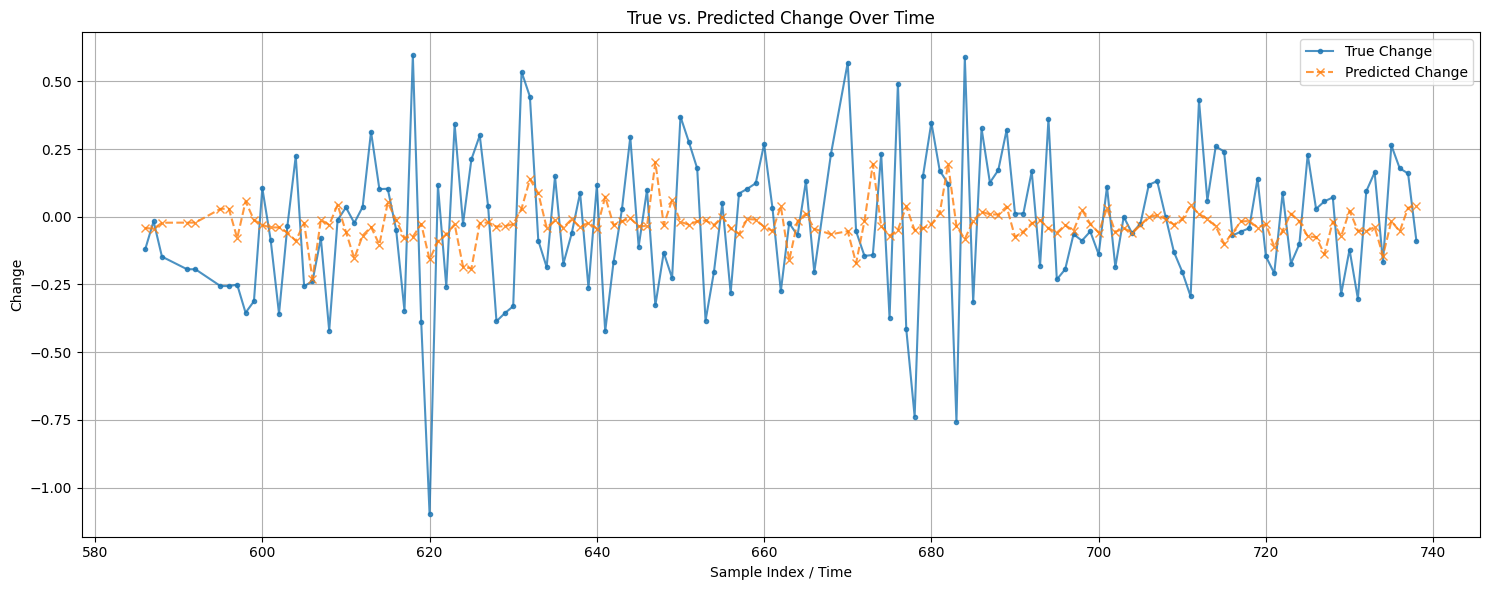

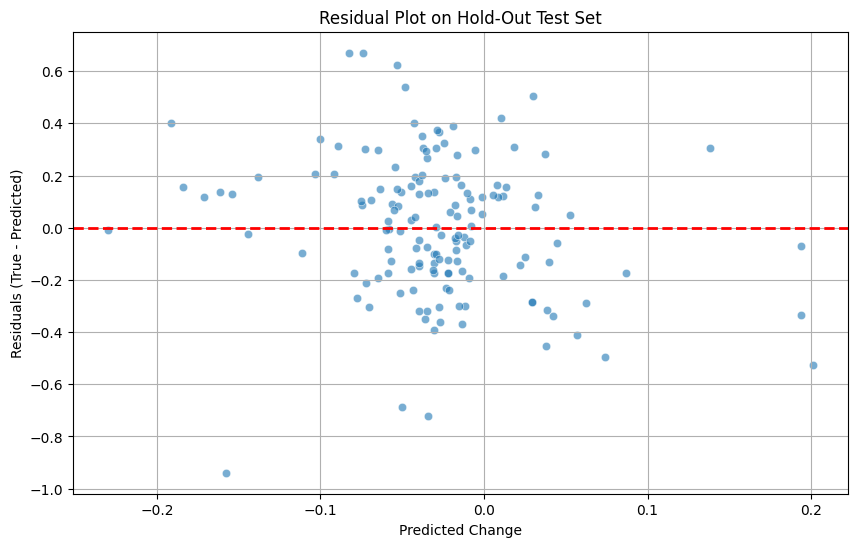

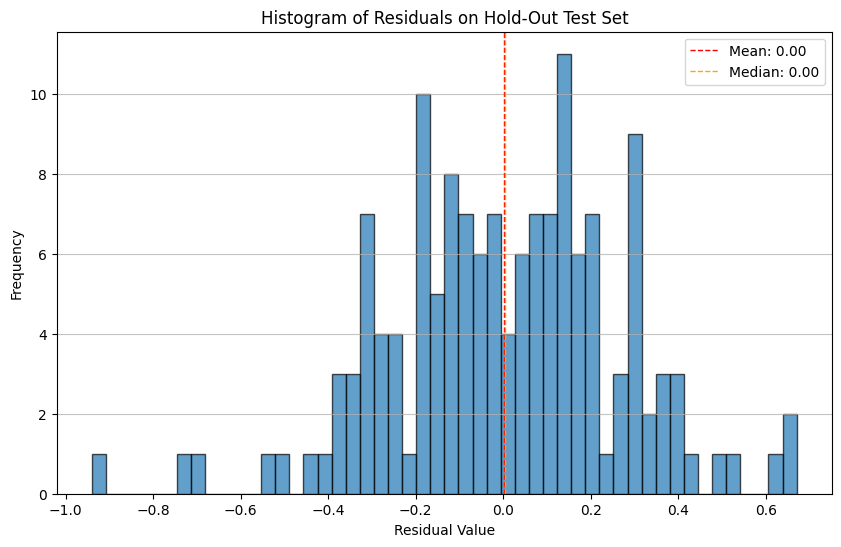

In [106]:

print("\n--- Detailed Comparison of True vs. Predicted Changes ---")

# 1. Numerical Output: Side-by-side comparison and summary statistics
# Ensure y_test_holdout and y_pred_test_holdout are 1D arrays for DataFrame creation
true_changes_flat = y_test_holdout.flatten() if hasattr(y_test_holdout, 'flatten') else y_test_holdout
predicted_changes_flat = y_pred_test_holdout.flatten() if hasattr(y_pred_test_holdout, 'flatten') else y_pred_test_holdout

comparison_df = pd.DataFrame({
    'True Change': true_changes_flat,
    'Predicted Change': predicted_changes_flat
})

print("\nSample of True vs. Predicted Changes (First 10):")
print(comparison_df.head(10))

print("\nStatistical Summary of True Changes on Hold-Out Set:")
print(comparison_df['True Change'].describe())

print("\nStatistical Summary of Predicted Changes on Hold-Out Set:")
print(comparison_df['Predicted Change'].describe())


# 3. Visual Output: Line Plot (if your data has a natural sequence, e.g., time series)
# This is similar to the plot in Lecture 5, page 6.
# If your X_test_holdout or y_test_holdout has a time index, use that for the x-axis.
# For demonstration, we'll use a simple sample index if the dataset isn't too large.

# Check if the data is likely sequential and not too large to plot clearly
is_sequential_data = True # Assume true for now; you might have a better flag
num_test_samples = len(comparison_df)

if is_sequential_data and num_test_samples > 1:
    plt.figure(figsize=(15, 6))
    time_indices = X_test_holdout.index

    plt.plot(time_indices, comparison_df['True Change'], label='True Change', marker='.', linestyle='-', alpha=0.8)
    plt.plot(time_indices, comparison_df['Predicted Change'], label='Predicted Change', marker='x', linestyle='--', alpha=0.8)
    plt.xlabel("Sample Index / Time")
    plt.ylabel("Change")
    plt.title(f"True vs. Predicted Change Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout() # Adjust layout to make room for labels
    plt.show()
else:
    print("Skipping sequential line plot (data might not be sequential or too few/many points for a clear default plot).")

# 4. Optional but Recommended: Residual Plot
# Residuals can highlight systematic errors or biases in your model.
residuals = comparison_df['True Change'] - comparison_df['Predicted Change']

plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['Predicted Change'], residuals, alpha=0.6, edgecolors='w', linewidth=0.5)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted Change")
plt.ylabel("Residuals (True - Predicted)")
plt.title("Residual Plot on Hold-Out Test Set")
plt.grid(True)
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals on Hold-Out Test Set")
plt.axvline(residuals.mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {residuals.mean():.2f}')
plt.axvline(np.median(residuals), color='orange', linestyle='dashed', linewidth=1, label=f'Median: {np.median(residuals):.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()


# [Your existing code for feature importance would go here]
# ...
# importance_df = pd.DataFrame({'feature': X_tuning_full.columns, 'importance': feature_importances})
# ...